**Explainable and Trustworthy AI**

**Explanations in Medicine**

In this notebook an analysis on a medicine dataset is done in order to examine the explanability of different machine learning models.

# **1. Introduction**

This dataset was collected by **Marzia Ahmed**, a researcher and software engineering student, with the aim of predicting the risk level for pregnant women in Bangladesh. The data was collected from various sources, including **hospitals**, **community clinics**, and **maternal health centers** located in rural areas of **Bangladesh**. 

The collection process involved two approaches: 

*   **IOT device:** an  IoT based maternal health  care system was designed to  detect the symptoms as well as the maternal health risk factor
*   **Questionnaire:** a questionnaire was created with the assistance of previous research in the field, as well as the expertise of medical professionals.

Maternal Health Risk Data Set location:
https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set 


# **2. Settings**

This section is aimed for importing files, installing software and loading the required Python libraries.

In [ ]:
## Most of the code in this notebook is based in code developed by Jose Maria Alonso-Moral

%%capture
import os

# FAT-forensics
os.system("pip install fat-forensics --quiet")
# shap is a XAI
os.system("pip install shap --quiet")
# lime is another XAI lib
os.system("pip install lime --quiet")
# Dtreeviz to visualize models of trees
os.system("pip install dtreeviz --quiet")
# Faces to visualize data
os.system("pip install facets-overview --quiet")
# simplenlg to translate to linguistic
os.system("pip install simplenlg --quiet")

# Loading csv package for reading data files
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import fatf
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.data.tools as fatf_data_tools
import fatf.utils.data.density as fatf_density
import fatf.utils.models as fatf_models
import fatf.utils.metrics.tools as fatf_metrics_tools
import fatf.utils.metrics.metrics as fatf_metrics
import fatf.utils.metrics.subgroup_metrics as fatf_smt
import fatf.accountability.models.measures as fatf_accountability_models
import fatf.accountability.data.measures as fatf_accountability_data
import fatf.accountability.data.measures as fatf_dam

import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.tree import export_text
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
import xgboost

# Tree graphics
import graphviz
import dtreeviz
# XAI graphics
import shap
import lime
import lime.lime_tabular

# Analysis graphics
from IPython.core.display import display, HTML
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import seaborn as sns
import plotly.express as px

# Loading the Realiser and corpus 
from simplenlg.framework import *
from simplenlg.lexicon import *
from simplenlg.realiser.english import *
from simplenlg.phrasespec import *
from simplenlg.features import *

INFO:fatf:External warning filters are being used.
INFO:fatf.utils.array.tools:Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [ ]:
# Size of the plots
plt.rcParams["figure.figsize"] = (15,10)

# **3. Data Explainability** 

### **Data analysis**

In this section we do a first analysis of the data we are going to use in out models.

First we start showing the general information of the dataset and encoding the string categorical values to numeric value so they can be processed for our machine learning models.

In [ ]:
# Load data
url_path="https://archive.ics.uci.edu/ml/machine-learning-databases/00639/Maternal%20Health%20Risk%20Data%20Set.csv"

# Names of features in each dataset (Dystolic removed, explanation in next section)
feature_name=["Age","SystolicBP","DiastolicBP","BS","BodyTemp","HeartRate"]
target_name = "RiskLevel"
class_name=["Low Risk", "Mid Risk", "High Risk"]

data= pd.read_csv(url_path)

print("Maternal Health Risk Data Set")
print(data.head())
print(data.dtypes)
print(data.describe())

# Transform the category feature to numeric values
data.RiskLevel = data.RiskLevel.replace(['low risk', 'mid risk', 'high risk'],[0,1,2])

Maternal Health Risk Data Set
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk
Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%  

Our dataset contains seven attributes related to the risk of maternal pregnancy:

*   **Age:** ages in years of the pregnant patiente. Numerical value.
*   **SystolicBP:** Upper value of Blood Pressure in mmHg. Numerical value.
*   **DiastolicBP:** Lower value of Blood Pressure in mmHg. Numerical value.
*   **BS:** Blood glucose levels is in terms of a molar concentration, mmol/L. Numerical value.
*   **BodyTemp:** temperature of the body. Numerical value.
*   **HeartRate:**  heart rate in beats per minute. Numerical value.
*   **Risk Level:** Risk Intensity Level during pregnancy. Categorical value.



### **General analysis**
We perform an analysis of the values in the dataset. Here we try to detect uncompleted values, outliers, relation between features, etc.




In [ ]:
# Get the counts of all the null values
null_values = data.isnull().sum()
# Get the counts of all the missing values
missing_values = data.isnull().sum()
# Get the counts of all the zero values. As one of the classification is zero, 
# the risk level will have values in this search
zero_values = data.eq(0).sum()

print("Null values:")
print(null_values)
print("Missing values:")
print(missing_values)
print("Zero values:")
print(zero_values)

Null values:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
Missing values:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
Zero values:
Age              0
SystolicBP       0
DiastolicBP      0
BS               0
BodyTemp         0
HeartRate        0
RiskLevel      406
dtype: int64


In [ ]:
# Display the Dive visualization for the data.
jsonstr = data.to_json(orient='records')
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-dive id="elem" height="600"></facets-dive>
        <script>
          var data = {jsonstr};
          document.querySelector("#elem").data = data;
        </script>"""
html = HTML_TEMPLATE.format(jsonstr=jsonstr)
display(HTML(html))

In [ ]:
gfsg = GenericFeatureStatisticsGenerator()

proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': data}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [ ]:
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

# This graphic have the missing and zero function integrated directly.
# As one of the classification is zero, 
# the risk level will have values in this search

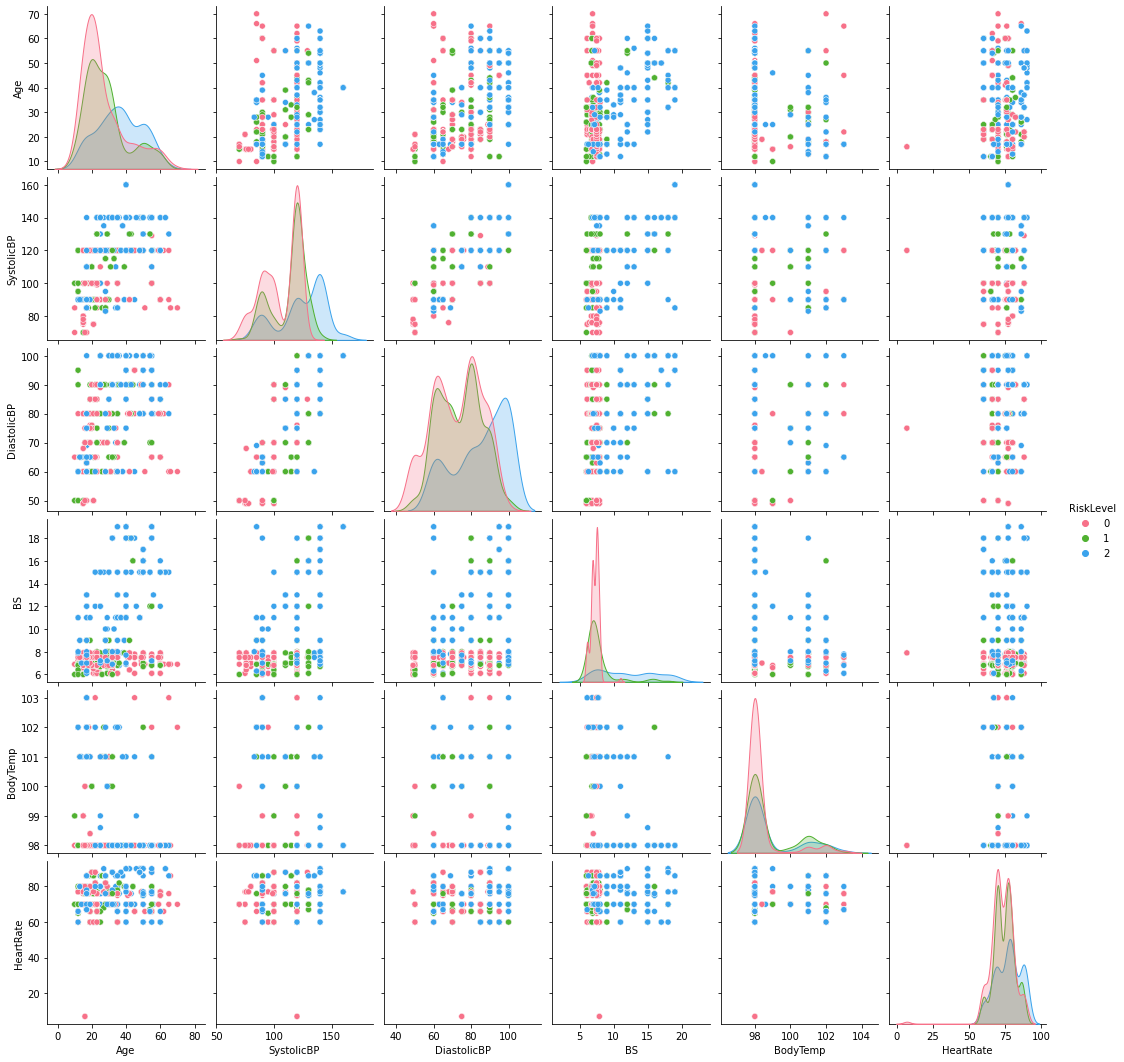

In [ ]:
sns.pairplot(data, hue=target_name, palette=sns.color_palette("husl", 3))

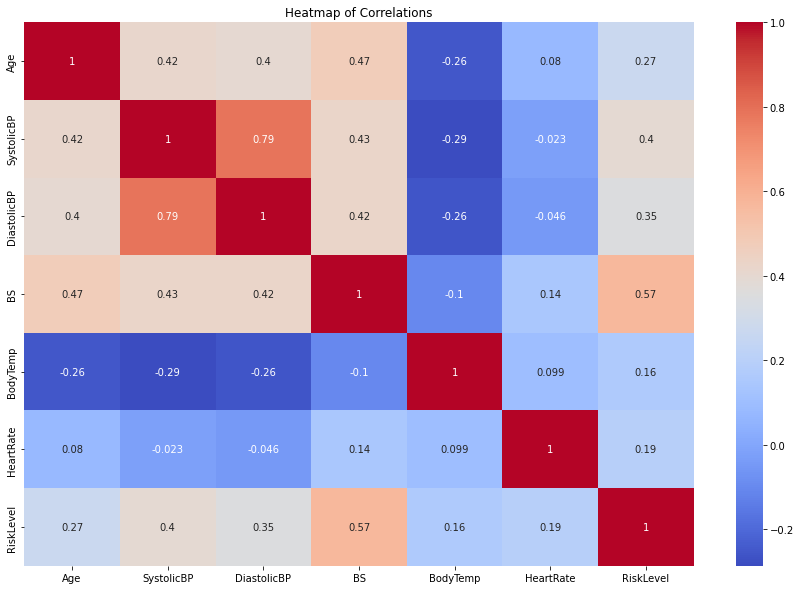

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Heatmap of Correlations")
plt.show()

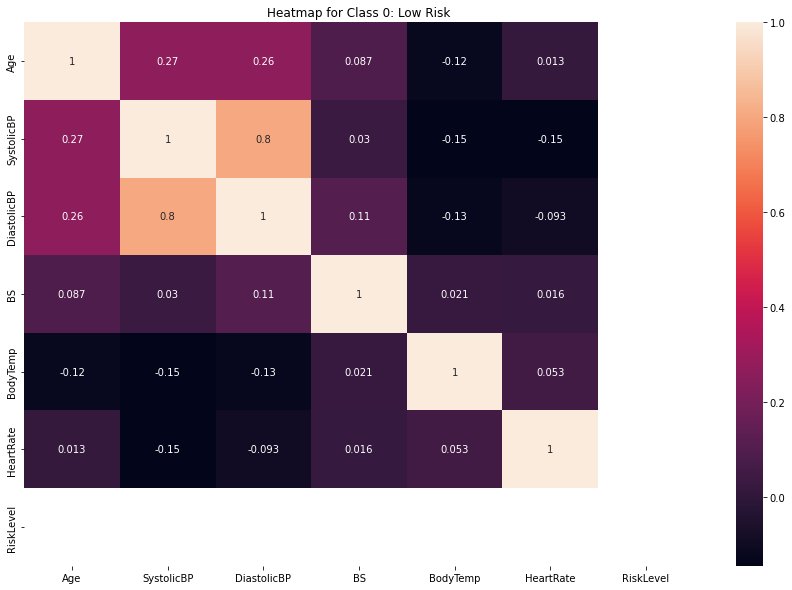

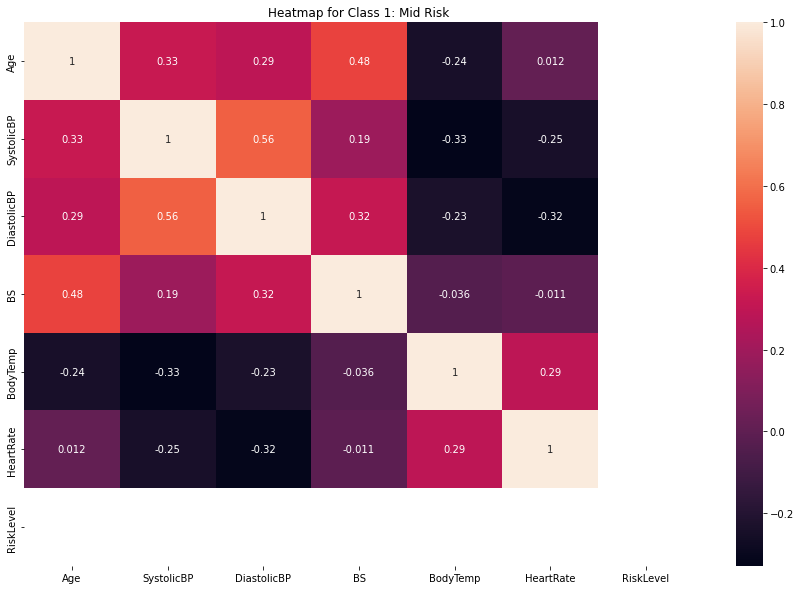

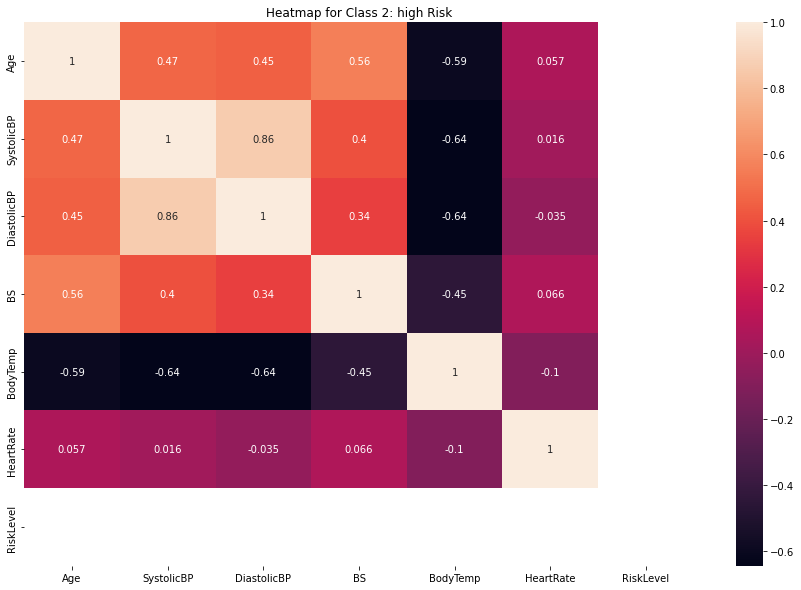

In [ ]:
class_1_data = data[data['RiskLevel'] == 0]
class_2_data = data[data['RiskLevel'] == 1]
class_3_data = data[data['RiskLevel'] == 2]

# Plot the heatmap for each class
sns.heatmap(class_1_data.corr(), annot=True)
plt.title('Heatmap for Class 0: Low Risk')
plt.show()

sns.heatmap(class_2_data.corr(), annot=True)
plt.title('Heatmap for Class 1: Mid Risk')
plt.show()

sns.heatmap(class_3_data.corr(), annot=True)
plt.title('Heatmap for Class 2: high Risk')
plt.show()

Text(0.5, 1.0, 'HeartRate')

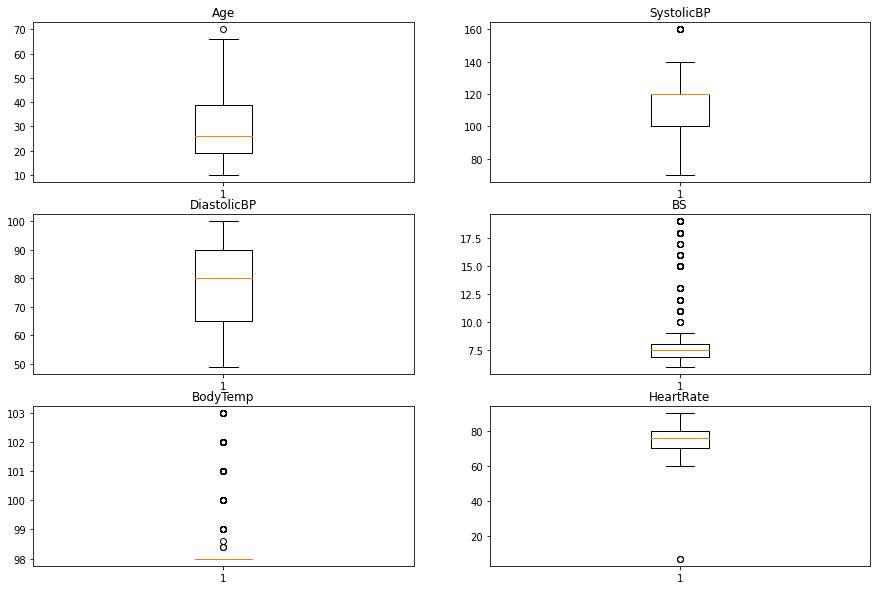

In [ ]:
fig, axs = plt.subplots(3,2)
#fig.suptitle('Outliers analysis')
axs[0,0].boxplot(data["Age"])
axs[0,0].set_title('Age')
axs[0,1].boxplot(data["SystolicBP"])
axs[0,1].set_title('SystolicBP')
axs[1,0].boxplot(data["DiastolicBP"])
axs[1,0].set_title('DiastolicBP')
axs[1,1].boxplot(data["BS"])
axs[1,1].set_title('BS')
axs[2,0].boxplot(data["BodyTemp"])
axs[2,0].set_title('BodyTemp')
axs[2,1].boxplot(data["HeartRate"])
axs[2,1].set_title('HeartRate')


As we seen in the previous analysis, in the dataset are several variables that could be outliers but as this is a medical problem and could be important. Thus, the only outliers that we are going to remove are the rows that have a heart rate value of 7 bpm. A normal resting heart rate for adults ranges from 60 to 100 beats per minute, so a person with this hear rate would not be alive.
The other outliers that we are going to remove are the ones regarding age from womens above 60 years and lower than 12, as the pregnancy at those ages is very rare.</br> </br>
Regading correlation, we detect that the column DiastolicBP and SystolicBP are higly correlated. Searching information about this correlations we find in https://www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings a table explaining it values and proced to remove DiastolicBP of our dataset. Also we decide to ask some medics about our study case in order to validate our project and they inform us of this correlation but that both values are important in their decisions, so we decide to keep both columns even with that level of correlation.

In [ ]:
# Remove outliers
data = data[data["HeartRate"] >= 50]
data = data[data["Age"] <= 60]
data = data[data["Age"] >= 12]

### **Features Distribution**</br>
In this section we do some explanatory data analysis on the distribution of the features and the relation with the risk level. This will also help us in the development of our fuzzy system.

**Age**

In [ ]:
fig = px.box(data, x=target_name, y="Age", points="all")
fig.show()

In [ ]:
for i in range (0,3):
  age_data = data[data['RiskLevel'] == i]

  fig = px.histogram(age_data['Age'], nbins=50, opacity=0.5)
  fig.update_layout(
      title='Age Distribution for class {}'.format(i),
      xaxis_title='Age',
      yaxis_title='Frequency'
  )
  fig.show()

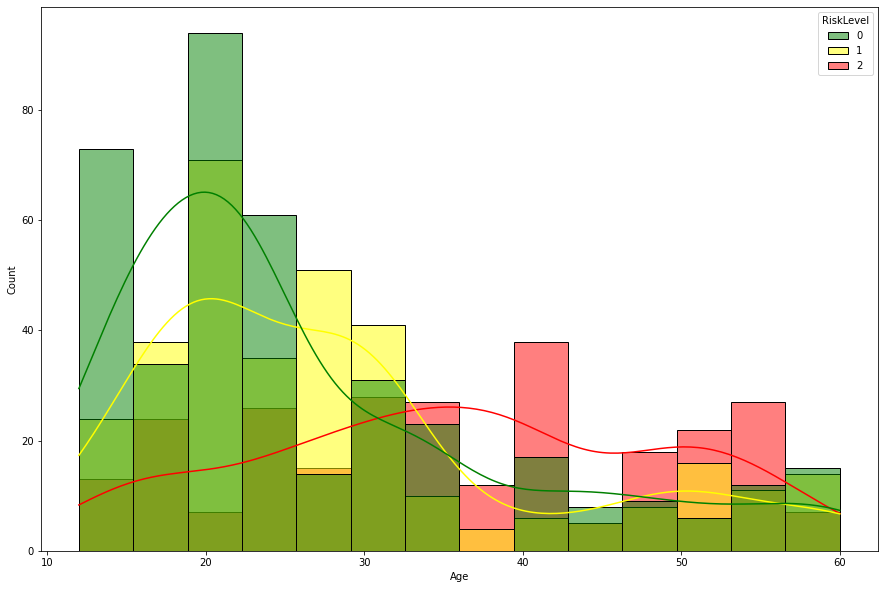

In [ ]:
sns.histplot(data=data, x="Age", hue=target_name, kde=True,  palette=['green','yellow','red'])
plt.show()

**DiastolicBP**

In [ ]:
fig = px.box(data, x=target_name, y="DiastolicBP", points="all")
fig.show()

In [ ]:
for i in range (0,3):
  dias_data = data[data['RiskLevel'] == i]

  fig = px.histogram(dias_data['DiastolicBP'], nbins=50, opacity=0.5)
  fig.update_layout(
      title='DiastolicBP Distribution for class {}'.format(i),
      xaxis_title='DiastolicBP',
      yaxis_title='Frequency'
  )
  fig.show()

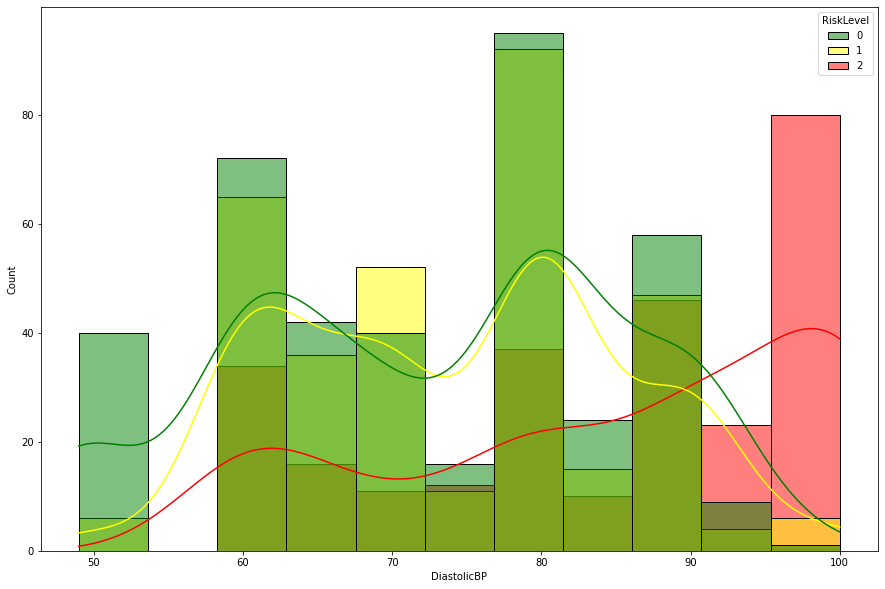

In [ ]:
sns.histplot(data=data, x="DiastolicBP", hue=target_name, kde=True,  palette=['green','yellow','red'])
plt.show()

**SystolicBP**

In [ ]:
fig = px.box(data, x=target_name, y="SystolicBP", points="all")
fig.show()

In [ ]:
for i in range (0,3):
  dias_data = data[data['RiskLevel'] == i]

  fig = px.histogram(dias_data['SystolicBP'], nbins=50, opacity=0.5)
  fig.update_layout(
      title='SystolicBP Distribution for class {}'.format(i),
      xaxis_title='SystolicBP',
      yaxis_title='Frequency'
  )
  fig.show()

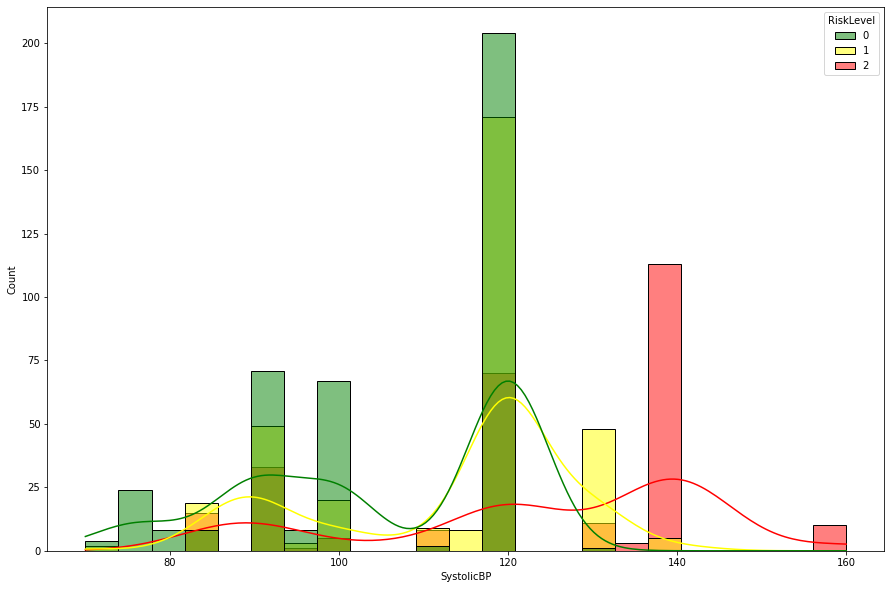

In [ ]:
sns.histplot(data=data, x="SystolicBP", hue=target_name, kde=True,  palette=['green','yellow','red'])
plt.show()

**Body Temperature**

In [ ]:
fig = px.box(data, x=target_name, y="BodyTemp", points="all")
fig.show()

In [ ]:
for i in range (0,3):
  dias_data = data[data['RiskLevel'] == i]

  fig = px.histogram(dias_data['BodyTemp'], nbins=50, opacity=0.5)
  fig.update_layout(
      title='BodyTemp Distribution for class {}'.format(i),
      xaxis_title='BodyTemp',
      yaxis_title='Frequency'
  )
  fig.show()

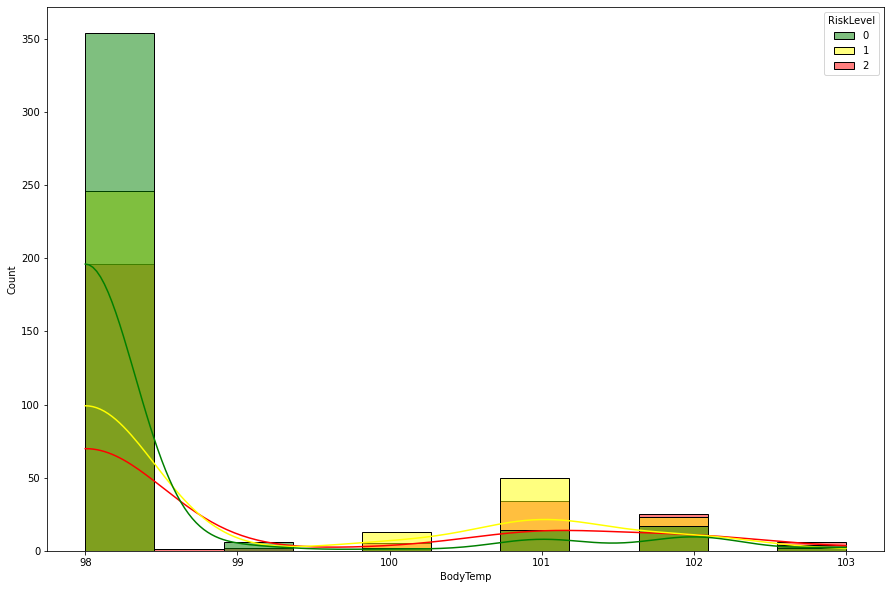

In [ ]:
sns.histplot(data=data, x="BodyTemp", hue=target_name, kde=True,  palette=['green','yellow','red'])
plt.show()

**BS**

In [ ]:
fig = px.box(data, x=target_name, y="BS", points="all")
fig.show()

In [ ]:
for i in range (0,3):
  dias_data = data[data['RiskLevel'] == i]

  fig = px.histogram(dias_data['BS'], nbins=50, opacity=0.5)
  fig.update_layout(
      title='BS Distribution for class {}'.format(i),
      xaxis_title='BS',
      yaxis_title='Frequency'
  )
  fig.show()

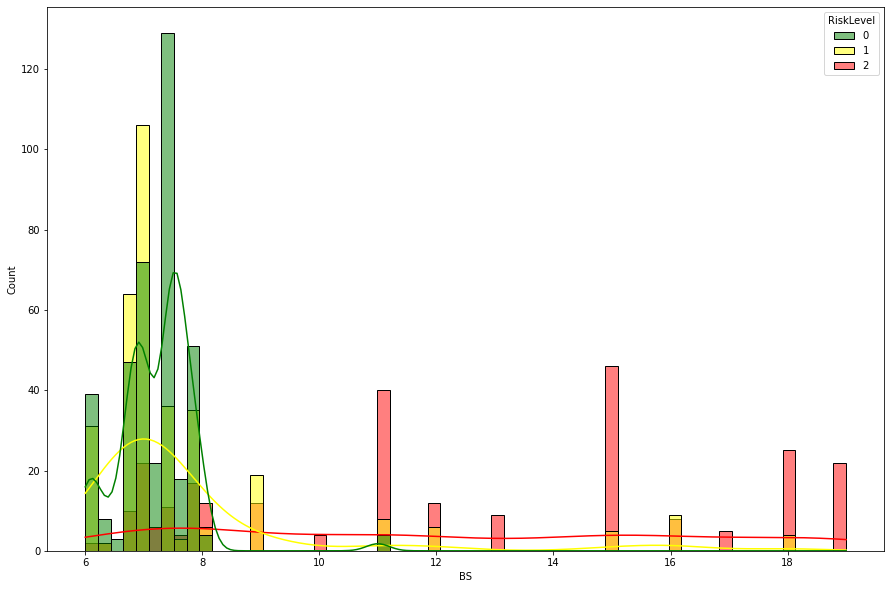

In [ ]:
sns.histplot(data=data, x="BS", hue=target_name, kde=True,  palette=['green','yellow','red'])
plt.show()

**Heart Rate**

In [ ]:
fig = px.box(data, x=target_name, y="HeartRate", points="all")
fig.show()

In [ ]:
for i in range (0,3):
  dias_data = data[data['RiskLevel'] == i]

  fig = px.histogram(dias_data['HeartRate'], nbins=50, opacity=0.5)
  fig.update_layout(
      title='Heart Rate Distribution for class {}'.format(i),
      xaxis_title='Heart Rate',
      yaxis_title='Frequency'
  )
  fig.show()

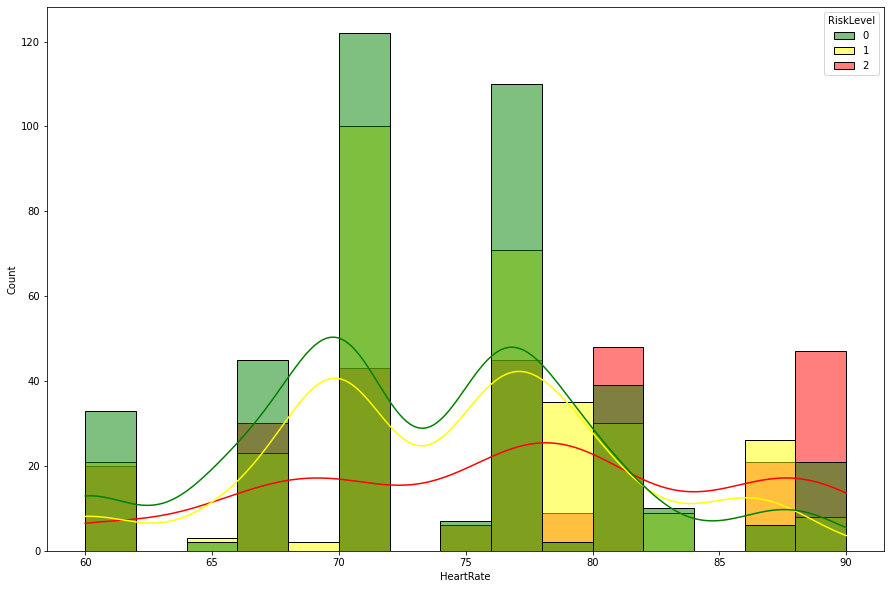

In [ ]:
sns.histplot(data=data, x="HeartRate", hue=target_name, kde=True,  palette=['green','yellow','red'])
plt.show()

After some explanatory analysis and based also in the previous correlations graphs, we can determinate wich features are more important and the values that determinate the threshold between the different levels of risks. For example, BS (Blood Sugar) seems like the most important feature and after a value of 8 the risk of the patient increseas rapidly.

### **Imbalanced analysis**

In this section we analyze the dataset target to determinate is there are imbalance in the information.

In [ ]:
fig = px.histogram(data, x=target_name)
fig.show()

In [ ]:
px.pie(values = data[target_name].value_counts().values, names = data[target_name].value_counts().index)

In [ ]:
print('Total rows:', data[target_name].count())
print('Low risk:', len(data[data[target_name]==0]))
print('Medium risk:', len(data[data[target_name]==1]))
print('High risk:',len(data[data[target_name]==2]))

Total rows: 1000
Low risk: 397
Medium risk: 334
High risk: 269


There are differences in the amount of values that correspond to each classes but not enought to consider the dataset as imbalanced.

### **Dataset split**

Now that we have completed the analysis in our dataset, we are going to divide it in order to leave it ready for our training

In [ ]:
# Split the dataset in features and targets
y =  data[target_name]

# Remove the 'RiskLevel' column
x = data.drop(target_name, axis=1)

In [ ]:
# Split the dataset en training and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### **Sampling bias**

All the columns expressed in the dataset contain medical information, even age, that could be taken as a protected atribute but in this case is important as it is a feature directly related to the risk in maternal healthcare during pregnancy. </br>
Blood sugar levels depend on if the patient has taken the test on fasting or no, different values will be expected to be correct or not depending on this data. As this is information is not provided in the dataset, we asume that the values correspond to fasting.</br>
The risk level associated to each pregnancy has the implict bias of each doctor evaluation, as not all of them have the same opinions on the level of risk each pregancy has. When we ask about our dataset and rules to two different specialist, they dont always agree in the definitions.

### **Metrics Analysis**
We select the metrics that we are going to use to evaluate our models

There are several metrics available to evaluate Machine Learning models like accuracy, recall, sensitivity, etc. </br> As this is a medical problem, the incorrect classification of the situation could lead to compromised health situation. The cost of failing to diagnose the disease of a sick person is much higher than the cost of sending a healthy person to more tests so is very important that we select the correct metric. 

Next we show a little definition of each possible evaluation metric for the models: </br>

**True Positives** : The cases in which we predicted YES and the actual output was also YES.</br>
**True Negatives** : The cases in which we predicted NO and the actual output was NO.</br>
**False Positives** : The cases in which we predicted YES and the actual output was NO.</br>
**False Negatives** : The cases in which we predicted NO and the actual output was YES.</br>

**True Positive Rate (Sensitivity)** : True Positive Rate is defined as TP/ (FN+TP). True Positive Rate corresponds to the proportion of positive data points that are correctly considered as positive, with respect to all positive data points.

**True Negative Rate (Specificity)** : True Negative Rate is defined as TN / (FP+TN). False Positive Rate corresponds to the proportion of negative data points that are correctly considered as negative, with respect to all negative data points.

**False Positive Rate** : False Positive Rate is defined as FP / (FP+TN). False Positive Rate corresponds to the proportion of negative data points that are mistakenly considered as positive, with respect to all negative data points.

**Precision** : It is the number of correct positive results divided by the number of positive results predicted by the classifier.

**Recall** : It is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive).

**F1 Score** tries to find the balance between precision and recall.

As we state on the begining, we have to address the issue of false negatives, so we need a metrics that is sensitive to the number of false negatives, so we selected **recall**, which is defined as the fraction of true positive samples (samples correctly classified as positive) out of all positive samples (both true positives and false negatives). 

Recall = TP / (TP + FN).

Regarding the general evaluation between machine learning and fuzzy models, we decide to evaluate their interpretability comparing the number of leaves against the number or rules.

# **4. Model Explainability**

In this section we execute the training of our models and try to explain the desitions they are taking to classify the features.

## **Batch learning**

In this subsection we execute the batch learning models and show their performance and explainability.

We select five models to use in our experimentation: a Decision Tree with no depth limit, a Decision Tree with a limit of depth of five, a Random Forest Tree and a XGBoost.

The first two where select as Decision Tree have a high level of explanability against black box models like multilayer perceptrons. </br>
The Random Forest was selected to show the accuracy of an ensemble of this models.</br>
Finally XGBoost was select as its an upgrade of the classical decision trees and libraries like SHAP or dtreeviz can show some information how they are working inside. We use one with no limit and other with a depth limit of five.

In [ ]:
# Function to evaluate the models and show the metrics
def model_evaluation(models, models_names, x_train, y_train, x_test, y_test):
  scorings = {
      #'accuracy': make_scorer(accuracy_score),
      'recall_macro': make_scorer(recall_score, average='macro')
  }
  nF= 10

  cv_results=[]
  for i in range(0, len(models)):
    cv_results.append(cross_validate(models[i], x_train, y_train, cv=nF, 
                                scoring=scorings,
                                return_train_score=False))

  for i in range(0, len(models)):
    models[i].fit(x_train, y_train)
    y_pred = models[i].predict(x_test)

    cm = confusion_matrix(y_pred, y_test)
    
    print(models_names[i])
    #print('Cross Validation accuracy:',np.mean(cv_results[i]['test_accuracy']),'Std:', np.std(cv_results[i]['test_accuracy']))
    print('Cross Validation recall:',np.mean(cv_results[i]['test_recall_macro']),'Std:', np.std(cv_results[i]['test_recall_macro']))
    #print('Test Evaluation accuracy:', accuracy_score(y_test, y_pred))
    print('Test Evaluation recall:', recall_score(y_test, y_pred, average='macro'))
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_name)
    disp.plot(cmap=plt.cm.Blues)

    plt.show()

TREE
Cross Validation recall: 0.8278803621209535 Std: 0.028311466127777064
Test Evaluation recall: 0.8174396225243683


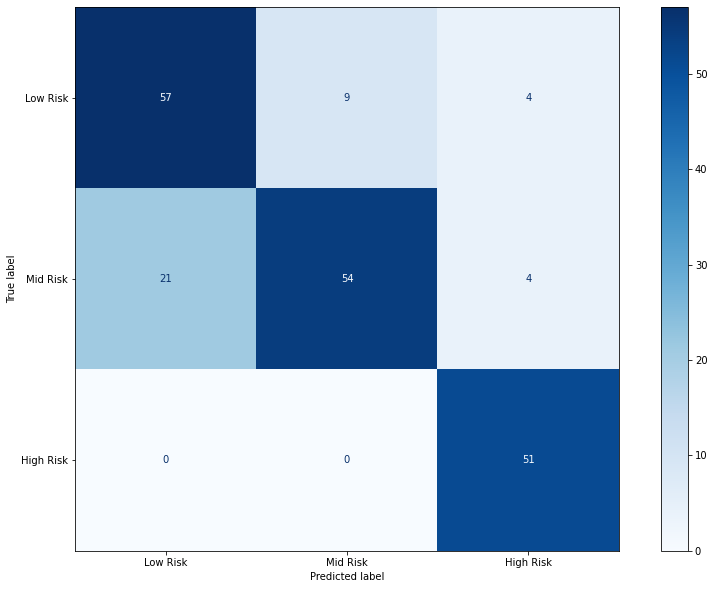

TREE5
Cross Validation recall: 0.6785593389088013 Std: 0.033540690205760205
Test Evaluation recall: 0.6960845181184165


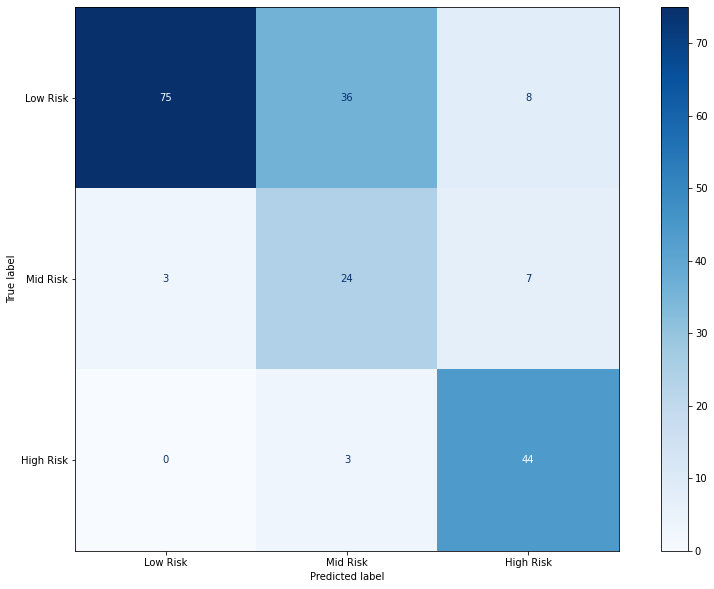

RF
Cross Validation recall: 0.8333592905501508 Std: 0.03257356487872058
Test Evaluation recall: 0.8536626587474045


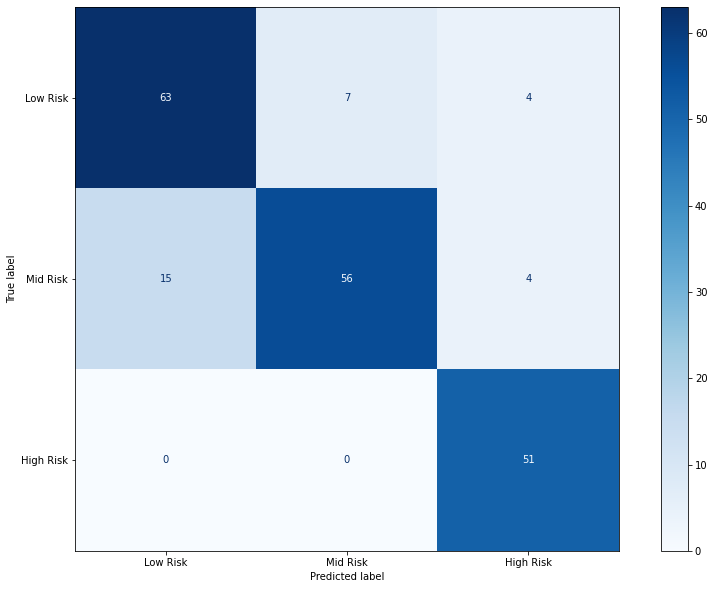

XGB
Cross Validation recall: 0.8291209748535016 Std: 0.03826380025741331
Test Evaluation recall: 0.8569186620034078


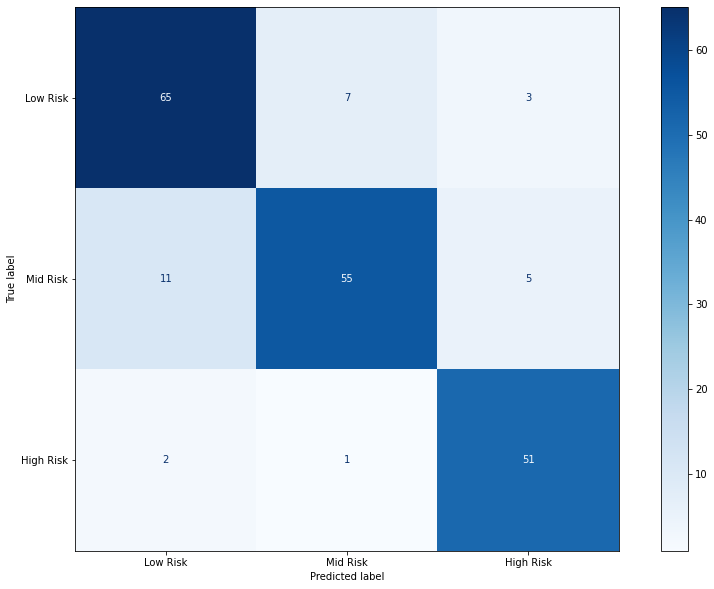

XGB5
Cross Validation recall: 0.8226780736189339 Std: 0.037497518663229396
Test Evaluation recall: 0.8526451577299036


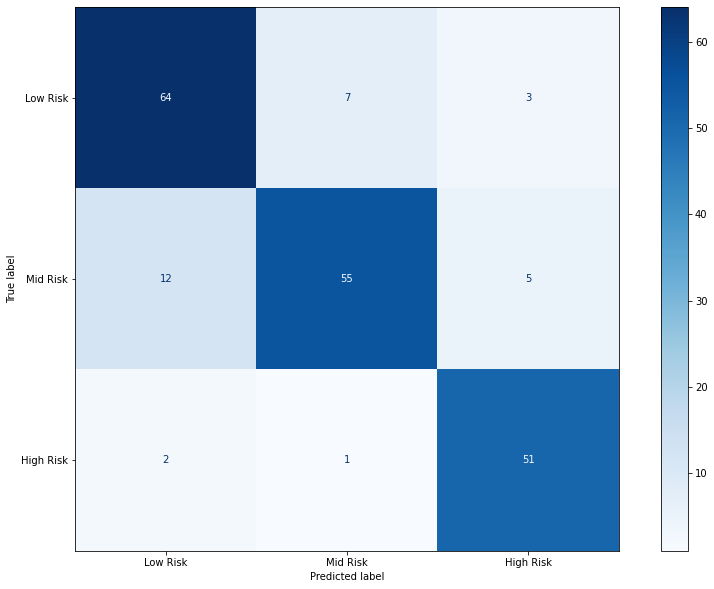

In [ ]:
# Create the five models and show the results
dtc = tree.DecisionTreeClassifier()
dtc5 = tree.DecisionTreeClassifier(max_depth=5)
randf = RandomForestClassifier(n_estimators=500)
xgb = xgboost.XGBClassifier(n_estimators=500)
xgb5 = xgboost.XGBClassifier(n_estimators=500, max_depth=5)

models = [dtc, dtc5, randf, xgb, xgb5]
models_names = ['TREE', 'TREE5', 'RF','XGB','XGB5']
model_evaluation(models, models_names, x_train, y_train, x_test, y_test)

In the previous cell we see the metrics of each of the four models. Next we will try to show how they are making their desitions.

In [ ]:
# To use later in classification of instances
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_train.values, feature_names=feature_name, class_names=class_name, mode='classification')

# **Decision tree**

In [ ]:
print("Leaves:", dtc.get_n_leaves())
txt_tree_clf = tree.export_text(dtc, feature_names=feature_name)
print(txt_tree_clf)

Leaves: 151
|--- BS <= 7.95
|   |--- SystolicBP <= 132.50
|   |   |--- BS <= 7.06
|   |   |   |--- BodyTemp <= 99.50
|   |   |   |   |--- SystolicBP <= 125.00
|   |   |   |   |   |--- DiastolicBP <= 49.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- DiastolicBP >  49.50
|   |   |   |   |   |   |--- BS <= 6.75
|   |   |   |   |   |   |   |--- DiastolicBP <= 75.00
|   |   |   |   |   |   |   |   |--- Age <= 27.00
|   |   |   |   |   |   |   |   |   |--- BS <= 6.05
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- BS >  6.05
|   |   |   |   |   |   |   |   |   |   |--- Age <= 13.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- Age >  13.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Age >  27.00
|   |   |   |   |   |   |   |   |   |--- Age <= 33.00
|   |   |   |   |   |   |   |   |   |   |--- Diastolic

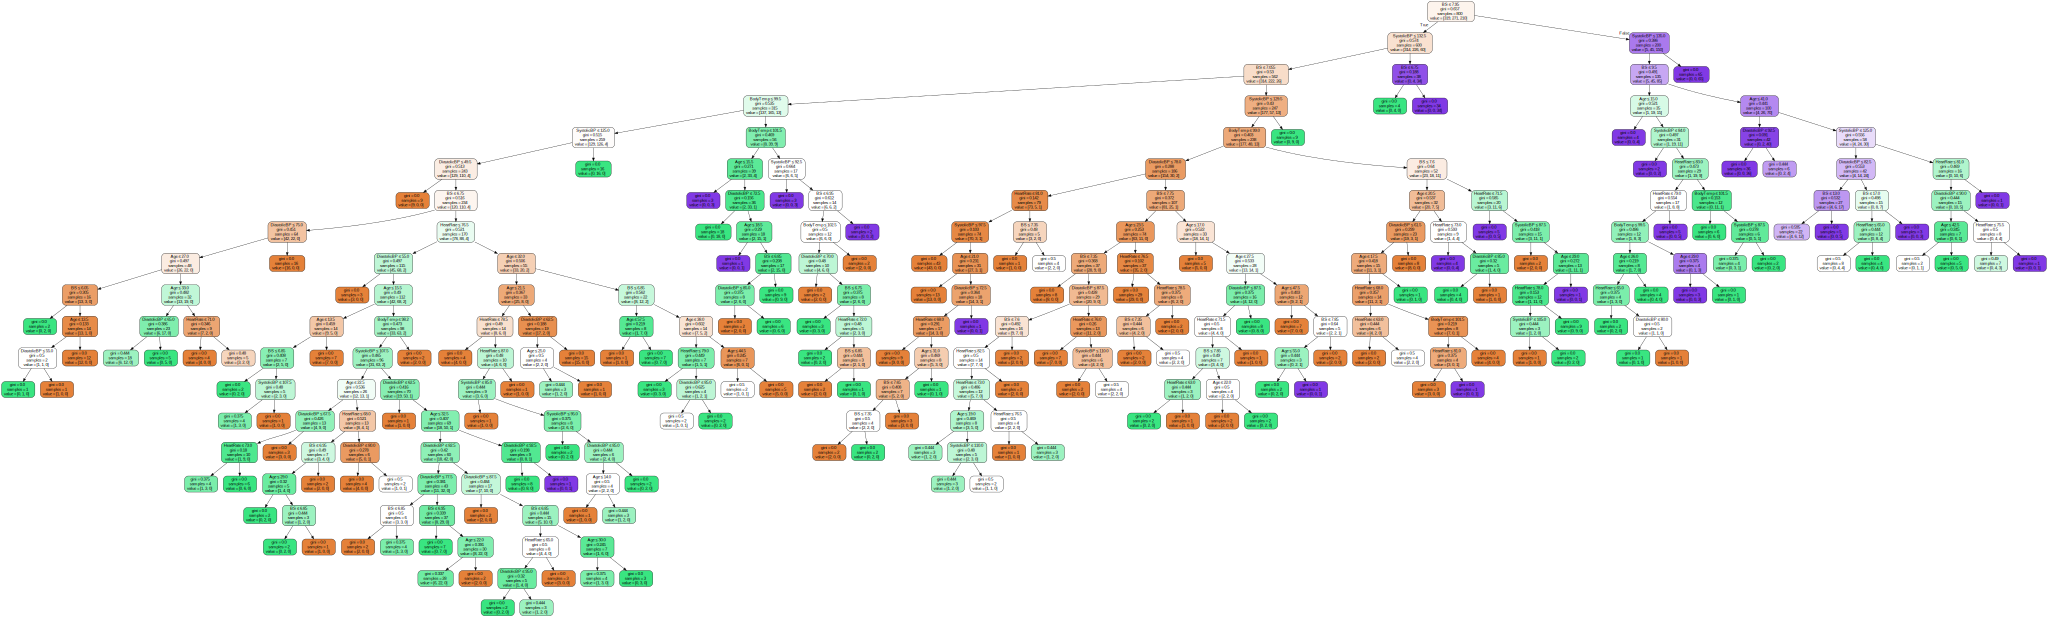

In [ ]:
dot_data = tree.export_graphviz(dtc, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=feature_name) 
graph = graphviz.Source(dot_data) 
graph

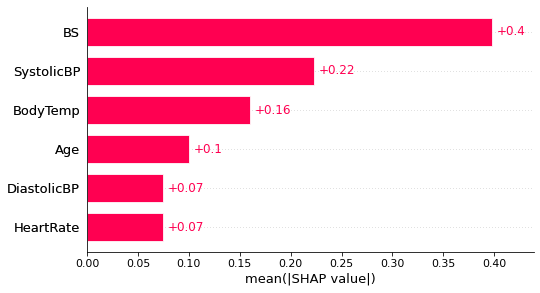

In [ ]:
# compute SHAP values
explainer = shap.Explainer(dtc.predict, x_train)
shap_values_dtc = explainer(x_train)

# plot SHAP values in a bar chart
shap.plots.bar(shap_values_dtc)

In [ ]:
print("Feature importance")
for i in range(0, len(feature_name)):
  print(feature_name[i], dtc.feature_importances_[i])

Feature importance
Age 0.16181036926342454
SystolicBP 0.1869943193479401
DiastolicBP 0.10254812776700013
BS 0.3920369357465948
BodyTemp 0.06210201708677848
HeartRate 0.09450823078826201


In [ ]:
tree_rep_dt = dtreeviz.model(dtc,X_train=x_train, y_train=y_train, feature_names=feature_name, class_names=class_name, target_name=target_name)
tree_rep_dt.view(fancy=True)

Output hidden; open in https://colab.research.google.com to view.

# **Decision tree depth 5**

In [ ]:
print("Leaves:", dtc5.get_n_leaves())
txt_tree_clf5 = tree.export_text(dtc5, feature_names=feature_name)
print(txt_tree_clf5)

Leaves: 17
|--- BS <= 7.95
|   |--- SystolicBP <= 132.50
|   |   |--- BS <= 7.06
|   |   |   |--- BodyTemp <= 99.50
|   |   |   |   |--- SystolicBP <= 125.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SystolicBP >  125.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- BodyTemp >  99.50
|   |   |   |   |--- BodyTemp <= 101.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- BodyTemp >  101.50
|   |   |   |   |   |--- class: 0
|   |   |--- BS >  7.06
|   |   |   |--- SystolicBP <= 129.50
|   |   |   |   |--- BodyTemp <= 99.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BodyTemp >  99.00
|   |   |   |   |   |--- class: 0
|   |   |   |--- SystolicBP >  129.50
|   |   |   |   |--- class: 1
|   |--- SystolicBP >  132.50
|   |   |--- BS <= 6.75
|   |   |   |--- class: 1
|   |   |--- BS >  6.75
|   |   |   |--- class: 2
|--- BS >  7.95
|   |--- SystolicBP <= 135.00
|   |   |--- BS <= 9.50
|   |   |   |--- Age <= 15.00
|   |   |   |   |--- class: 2
|   |   |   |

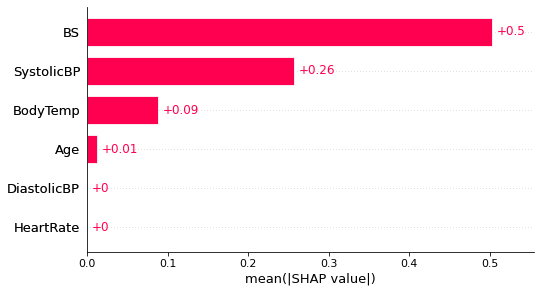

In [ ]:
# compute SHAP values
explainer = shap.Explainer(dtc5.predict, x_train)
shap_values_dtc5 = explainer(x_train)

# plot SHAP values in a bar chart
shap.plots.bar(shap_values_dtc5)

In [ ]:
explainer = shap.Explainer(xgb, x_train)
shap_values = explainer(x_train)

# create the force plot
shap.force_plot(explainer.expected_value, shap_values[0], x_train.iloc[0])

100%|===================| 2391/2400 [02:18<00:00]       

Exception: ignored

In [ ]:
# create the force plot
shap.force_plot(explainer.expected_value, shap_values[0], x_train.iloc[0])

In [ ]:
print("Feature importance")
for i in range(0, len(feature_name)):
  print(feature_name[i], dtc5.feature_importances_[i])

In [ ]:
dot_data = tree.export_graphviz(dtc5, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=feature_name) 
graph = graphviz.Source(dot_data) 
graph

In [ ]:
tree_rep_dt5 = dtreeviz.model(dtc5,X_train=x_train, y_train=y_train, feature_names=feature_name, class_names=class_name, target_name=target_name)
tree_rep_dt5.view(fancy=True)

In [ ]:
dot_data = tree.export_graphviz(dtc5, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=feature_name) 
graph = graphviz.Source(dot_data) 
graph

# **Random Forest**

In [ ]:
# compute SHAP values
explainer = shap.Explainer(randf.predict, x_train)
shap_values_randf = explainer(x_train)

# plot SHAP values in a bar chart
shap.plots.bar(shap_values_randf)

In [ ]:
print("Feature importance")
for i in range(0, len(feature_name)):
  print(feature_name[i], randf.feature_importances_[i])

# **XGBoost**

In [ ]:
# compute SHAP values
explainer = shap.Explainer(xgb.predict, x_train)
shap_values_xgb = explainer(x_train)

# plot SHAP values in a bar chart
shap.plots.bar(shap_values_xgb)

In [ ]:
print("Feature importance")
for i in range(0, len(feature_name)):
  print(feature_name[i], xgb.feature_importances_[i])

In [ ]:
tree_rep_xgb = dtreeviz.model(xgb,X_train=x_train, tree_index=1, y_train=y_train, feature_names=feature_name, class_names=class_name, target_name=target_name)
tree_rep_xgb.view(fancy=False)

# **XGBoost depth 5**

In [ ]:
# compute SHAP values
explainer = shap.Explainer(xgb5.predict, x_train)
shap_values_xgb5 = explainer(x_train)

# plot SHAP values in a bar chart
shap.plots.bar(shap_values_xgb5)

In [ ]:
print("Feature importance")
for i in range(0, len(feature_name)):
  print(feature_name[i], xgb5.feature_importances_[i])

In [ ]:
num_leaves = 2 ** xgb5.max_depth
print('Number of leaves:', num_leaves)

tree_rep_xgb5 = dtreeviz.model(xgb5,X_train=x_train, tree_index=1, y_train=y_train, feature_names=feature_name, class_names=class_name, target_name=target_name)
tree_rep_xgb5.view(fancy=False)

In [ ]:
from xgboost import to_graphviz
from xgboost import plot_tree
from xgboost import plot_importance
#dot_data = tree.export_graphviz(dtc5, out_file=None, filled=True, rounded=True, special_characters=True, feature_names=feature_name) 
graph = to_graphviz(xgb5, num_trees=0, filled=True)
graph

# Section summary

As we can see in the cells above, there are many ways to represent trees and xboost models to give a more comprensive way of showing how they are working. Also to obtain what are the most important features of the model after training. In this case we use SHAP, Lime, dtreeviz and even the functions from sklearn, but there are also other options like InterpretML or ELI5. </br>
In the results sections we can see the execution of the first case of the dataset with the explanability aproach, where we show the use of this tools with an instance adding also Lime results.

## **Fuzzy model**

For making our fuzzy model, we decide to use Matlab, a programming and numeric computing platform used to analyze data, develop algorithms, and create models.An exportation of this file is attached to the delivery as another jupyter notebook with the results.

## **Linguistic explanations**

In this section, we adds some linguist explanations to our models predictions using NLG library. The execution of this explanations for instances can be seen in the results section.

In [ ]:
lexicon = Lexicon.getDefaultLexicon()
nlgFactory = NLGFactory(lexicon)
realiser = Realiser(lexicon)

In [ ]:
# Auxiliary functions to help with the explanation generator

# Get the value of the field
def get_value(str_field, dataInput):
  # For each value in the datainput, compare the name of the column
  for i in range(0, len(dataInput)):
    if str_field == feature_name[i]:
      return dataInput[i]

# Get the linguistic operator of the mathematical operator
def get_linguistic_operator(node_operator):
  if node_operator == ">":
    return "greater"
  elif node_operator == ">=":
    return "greater or equal"
  elif node_operator == "<":
    return "lower"
  elif node_operator == "<=":
    return "lower or equal"
  else:
    return"equal"

# Get the linguistic target
def get_linguistic_target(target):
  if target == 0:
    return "Low risk"
  elif target == 1:
    return "Medium risk"
  else:
    return "High risk"

In [ ]:
# Given the fired rule and the data input, generates a verbalization
def explanationGenerator(firedRule, dataInput):
  rules = firedRule.split("THEN")[0]
  target = firedRule.split("THEN")[1]
  target = get_linguistic_target(float(target.split(":")[1].strip()))
  sentences_aux = []
  sentence1 = nlgFactory.createClause()

  for s in rules.split("&&"):
    node = s.strip().split(" ")

    # Get the value of the input to compare against the node
    input_value = get_value(node[0], dataInput)
   
    # Get the linguistic object
    lg_obj = get_linguistic_operator(node[1]) + " than " + node[2]

    sentence2 = nlgFactory.createClause()
    subj2 = nlgFactory.createNounPhrase("the", node[0] + " value "+ str(input_value))
    sentence2.setSubject(subj2)
    verb2= nlgFactory.createVerbPhrase("be")
    sentence2.setVerb(verb2)
    sentence2.setFeature(Feature.TENSE, Tense.PRESENT)
    obj2 = nlgFactory.createNounPhrase(lg_obj)
    sentence2.setObject(obj2)

    # Add to an auxiliar list of posible sentences
    sentences_aux.append(sentence2)

  # Add the linguistic explanation of the target      
  subj1 = nlgFactory.createNounPhrase("the", "output class")
  sentence1.setSubject(subj1)
  verb1= nlgFactory.createVerbPhrase("be")
  sentence1.setVerb(verb1)
  sentence1.setFeature(Feature.TENSE, Tense.PRESENT)
  obj1 = nlgFactory.createNounPhrase(target)
  sentence1.setObject(obj1)

  sentence = nlgFactory.createCoordinatedPhrase()
  first = False

  # For each auxiliary sentence, add to the explanation
  for s in sentences_aux:
    if first == False:
      s.setFeature(Feature.COMPLEMENTISER, "because")
      sentence1.addComplement(s)
      sentence = nlgFactory.createCoordinatedPhrase()
      sentence.addCoordinate(sentence1)
      first = True
    else:
      sentence.addCoordinate(s)

  return realiser.realiseSentence(sentence)

In [ ]:
# Get if the condition is fullfilled by the node
def validate_node(node_operator, node_value, value):
  if node_operator == ">" or node_operator == ">=":
    return value > node_value
  elif node_operator == "<" or node_operator == "<=":
    return value < node_value
  else:
    return value == node_value

# Get the node from the tree
def get_node(current_tree, lvl):
    for s in current_tree:
      # Get the level of the tree
      str_lvl = s.count('|')

      # If the level match, return values
      if str_lvl == lvl:
        vals = s.split('--- ')
        vals = vals[1].replace('  ',' ').split(' ')
      
        # If the representation of the tree has not been truncated
        if vals[0] != 'truncated':
          # If is not a class
          if (len(vals)==3):
            return [vals[0], vals[1], vals[2]]
          else:
            return [vals[0], float(vals[1])]

# Remove the node of the tree
def remove_node(current_tree, lvl):
  #remove current head
  current_tree.pop(0)
  aux_tree = current_tree.copy()

  #remove childs
  for s in aux_tree:
      # Get the level of the tree
      str_lvl = s.count('|')

      # Remove child till reach the next node with the level of the parent
      if str_lvl > lvl:
        current_tree.pop(0)
      else:
        break

In [ ]:
# Given the fired rule and the data input, generates a verbalization
def explanationTreeGenerator(tree, dataInput): 
  # Initialize variables
  node = [0,0,0]
  lvl = 1
  sentence = ""
  first = False
  current_tree = []
  for s in tree.split("\n"):
    current_tree.append(s)

  # While no final class have been reached
  while (len(node)==3):
    # Get the next node to evaluate
    node = get_node(current_tree, lvl)

    # If the node is a final class
    if (len(node)==2):
      sentence = sentence + "THEN class: " + str(node[1])
    # If the node is a new leaf
    else:
      # Get the value of the input to compare against the node
      input_value = get_value(node[0], dataInput)
      # Parse to float the node comparition value
      node_value = float(node[2])
      # Validate if the rule is fullfilled
      result = validate_node(node[1],node_value, input_value)

      # If rule fullfilled, continue with the childs of this node
      if (result==True):
        lvl = lvl + 1

        if first == False:
          sentence = node[0] + " " + node[1] + " " + node[2] + " "
          first = True
        else:
          sentence = sentence + "&& " + node[0] + " " + node[1] + " " + node[2] + " "
          
          # Get the linguistic object
          lg_obj = get_linguistic_operator(node[1]) + " than " + node[2]

      # Remove the node because rule was not fullfilled
      else:
        remove_node(current_tree, lvl)

  # Call to the previous defined explanation generator
  return explanationGenerator(sentence, dataInput)

# **5. Results**

In this section we execute the model for a determinate instance, showing the puntual explanability and interpretability available for this case. At the end of the section we show the linguist explanation generated for the decision trees.

In [ ]:
# Values of the case
x_test.iloc[0]

## Decision Tree

In [ ]:
# Visualize the decision tree prediction path
print("Decision tree")
tree_rep_dt.view(x=x_test.iloc[0], show_just_path=True)

In [ ]:
# visualizing SHAP for single instance
shap.plots.waterfall(shap_values_dtc[0])

In [ ]:
explainer = shap.Explainer(dtc.predict, x_train)
shap_values = explainer(x_test.iloc[0])

# visualize the SHAP values using force_plot
shap.force_plot(explainer.expected_value, shap_values, x_test.iloc[0])

In [ ]:
# compute SHAP values
explainer = shap.Explainer(dtc.predict, x_train)
shap_values_xgb5 = explainer(x_train)

# plot SHAP values in a bar chart
shap.plots.bar(shap_values_xgb5)

In [ ]:
# Visualize Lime for single instance
explanation = lime_explainer.explain_instance(x_test.iloc[[0]].values[0], dtc.predict_proba, num_features=len(feature_name))

explanation.as_pyplot_figure()

## Decision Tree depth five

In [ ]:
# Visualize the decision tree prediction path
print("Decision tree depth five")
tree_rep_dt5.view(x=x_test.iloc[0], show_just_path=True)

In [ ]:
# visualizing SHAP for single instance
shap.plots.waterfall(shap_values_dtc5[0])

In [ ]:
# Visualize Lime for single instance
explanation = lime_explainer.explain_instance(x_test.iloc[[0]].values[0], dtc5.predict_proba, num_features=len(feature_name))

explanation.as_pyplot_figure()

## Random Forest

In [ ]:
print("Random Forest")
# Visualize Lime for single instance
explanation = lime_explainer.explain_instance(x_test.iloc[[0]].values[0], randf.predict_proba, num_features=len(feature_name))

explanation.as_pyplot_figure()

## XGBoost

In [ ]:
# Visualize the xgboost prediction path
print("XGBoost")
tree_rep_xgb.view(x=x_test.iloc[0], show_just_path=True)

In [ ]:
# visualizing SHAP for single instance
shap.plots.waterfall(shap_values_xgb[0])

In [ ]:
# Visualize Lime for single instance
explanation = lime_explainer.explain_instance(x_test.iloc[[0]].values[0], xgb.predict_proba, num_features=len(feature_name))

explanation.as_pyplot_figure()

## XGBoost depth five

In [ ]:
# Visualize the xgboost prediction path
print("XGBoost depth five")
tree_rep_xgb5.view(x=x_test.iloc[0], show_just_path=True)

In [ ]:
# visualizing SHAP for single instance
shap.plots.waterfall(shap_values_xgb5[0])

In [ ]:
# Visualize Lime for single instance
explanation = lime_explainer.explain_instance(x_test.iloc[[0]].values[0], xgb5.predict_proba, num_features=len(feature_name))

explanation.as_pyplot_figure()

## Verbalization

In [ ]:
print("Clf verbalization:", explanationTreeGenerator(txt_tree_clf, x_test.iloc[0]))
print("Clf5 verbalization:", explanationTreeGenerator(txt_tree_clf5, x_test.iloc[0]))

## Final summary

As we can see, the tree graph explanability of the execution is understandable for anyone that knows about decisition trees in general and the linguistic explanation allows a non specialized person to understand in human language terms how we reach this conclusion.

Further improvements of the linguist model can be done to make it even more accesible, for example using representation of ranges instead of numeric values.

With the use of Lime for instances we can have extra information that the one provided by SHAP, giving us a better interpretability of black box model.

# **6. Conclusions and references**

The conclusions and references of this notebook are displayed in the report of the project.